In [1]:
import gym
import time
import pybulletgym  # register PyBullet enviroments with open ai gym
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.multivariate_normal import MultivariateNormal

np.set_printoptions(suppress=True, precision=4)

In [2]:
class Policy(nn.Module):

    def __init__(self, num_classes, lr):
        super(Policy, self).__init__()
        
        self.sigma = nn.parameter.Parameter(torch.tensor([[0.1, 0.], [0., 0.1]]))
        
        self.fc1 = nn.Linear(8, 64)
        self.hidden = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.tanh = nn.Tanh()
        
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        
    def forward(self, x):
        
        x = self.fc1(x) #input
        x = self.tanh(x)
        x = self.hidden(x) #layer 1
        x = self.tanh(x)
        x = self.hidden(x) #layer 2
        x = self.tanh(x)
        x = self.fc2(x) #layer 3
        x = self.tanh(x)

        sigma = torch.relu(self.sigma) + torch.tensor([[0.001, 0.], [0., 0.001]])

        return x, sigma

def makePolicyNN(num_actions=2, lr=0.01):
    ''' Initialize the policy class '''
    assert isinstance(num_actions, int) and num_actions>0
    
    return Policy(num_actions, lr)

In [3]:
class PolicyGradient:
    def __init__(self, gamma, N=500, max_steps=1000):
        ''' Initialize the Reacher PyBullet environment '''
        assert isinstance(gamma, float) and 0.0<gamma<1.0, 'Invalid gamma'
        assert isinstance(N, int) and N>0
        assert isinstance(max_steps, int) and max_steps>0
        
        self.env = gym.make("modified_gym_env:ReacherPyBulletEnv-v1", rand_init=False)
        self.gamma = gamma
        self.N = N
        self.max_steps = max_steps
        self.numActions = 2
        self.numObs = 8
        self.num_steps = 0
        self.max_steps_reached = False
        
    def saveModel(self, index):
        ''' Saves the policy NN'''
        filename = 'q2_policy' + str(index) + '.pth.tar'
        torch.save(self.state, filename)

    def getAction(self, policy_network, state):
        ''' Return an action from a stochastic policy '''
        assert isinstance(state, np.ndarray) and len(state) == self.numObs
        
        state = torch.from_numpy(state).float()
        torque_mean, torque_sigma = policy_network(state) #forward pass
        
        # Sampling from the 2D Gaussian and calculating the actions log probability
        m = MultivariateNormal(torque_mean, torque_sigma)
        action = m.sample()
        log_prob_of_action = m.log_prob(action)

        return action, log_prob_of_action
    
    def runEpisode(self, policy_network):
        ''' Generate [s_t, a_t, r_t] pairs for one episode '''
        
        state = self.env.reset()
        done = False
        rewards, log_prob_of_actions = [], []
        while not(done):
            a, lpa = self.getAction(policy_network, state)
            state, r, done, info = self.env.step(np.array(a))
            r = rewards.append(r)
            log_prob_of_actions.append(lpa)
            self.num_steps += 1 #incrementing total number of steps in one iteration
            if self.num_steps >= self.max_steps: #checking
                self.max_steps_reached = True
                break;
        
        return rewards, log_prob_of_actions

    def doReinforcePart3(self, policy_network, verbose=False):
        ''' Modified Reinforce algo which subtracts bias form returns '''
        
        gamma = self.gamma
        arr_objective = []
        avg_returns = np.zeros((self.N,))
        num_episodes = np.zeros((self.N,))
        sigma = np.zeros((self.N, 2))
        
        for i in range(self.N): #improving policy for "self.N" number of iterations
            n, objective = 0, 0
            policy_network.optimizer.zero_grad()
            
            # Resetting variables
            self.num_steps = 0
            self.max_steps_reached = False
            g, rewards, lpas = [], [], []
            
            # Looping until a maximum number of steps are taken
            while not(self.max_steps_reached):
                # Run an episode with policy and count number of steps taken
                r, log_prob_of_actions = self.runEpisode(policy_network)
                n += 1 #increasing count of episodes by 1
                # Collecting rewards and log_probs from all apisodes
                rewards.append(r)
                lpas.append(log_prob_of_actions)
                
                # Calculating g_{i} for each step to calculate the bias
                T = len(r)
                for j in range(T):
                    modified_return = 0
                    for t in range(j, T):
                        modified_return += r[j]*gamma**(t-j)
                    g.append(modified_return)
            assert len(g) == self.num_steps, 'Length of g ({0}) == number of steps ({1})'.format(len(g), self.num_steps)
            # Calculating bias
            b = np.mean(np.array(g)) 
            
            # Calculating objective
            for r, log_prob_of_actions in zip(rewards, lpas):
                T = len(r)
                for t in range(T):
                    modified_return = 0
                    for t_prime in range(t, T):
                        modified_return += r[t_prime]*gamma**(t_prime - t)
                    objective += log_prob_of_actions[t]*(modified_return - b)
                # Calculating average returns
                avg_returns[i] += sum(r)
            
            # Updating policy
            objective = -objective/n #averaging over n episodes and flipping sign so it does gradient ascent
            objective.backward()
            policy_network.optimizer.step()
            
            # Storing values to plot
            arr_objective.append(objective.item())
            avg_returns[i] /= n
            num_episodes[i] = n
            sigma0, sigma1 = policy_network.sigma[0,0].item(), policy_network.sigma[1,1].item()
            sigma[i,:] = np.array([sigma0, sigma1])

            if verbose and (i%5 == 0):
                print('Iteration: {0} \t Objective: {1:.3f} \t Average reward: {2:.3f} \t Num_episodes: {3}'\
                      .format(i, objective, avg_returns[i], num_episodes[i]))
        
        self.state = { 'state_dict': policy_network.state_dict(),
                      'optimizer': policy_network.optimizer.state_dict() }

        return policy_network, arr_objective, avg_returns, num_episodes, sigma

In [4]:
torch.manual_seed(420)
render_env = True
plot = True

policy_network = makePolicyNN(num_actions=2, lr=1e-3)
# list(policy_network.parameters())
pg = PolicyGradient(gamma=0.9, N = 100, max_steps=3000)
policy_network, arr_objective, avg_returns, num_episodes, sigma = pg.doReinforcePart3(policy_network, verbose=True)

current_dir=/Users/adnanshahpurwala/anaconda3/envs/ece276c_venv/lib/python3.6/site-packages/pybullet_envs/bullet
options= 
Iteration: 0 	 Objective: -2.322 	 Average reward: -25.934 	 Num_episodes: 21.0
Iteration: 5 	 Objective: -3.520 	 Average reward: -29.925 	 Num_episodes: 20.0
Iteration: 10 	 Objective: -2.700 	 Average reward: -25.544 	 Num_episodes: 22.0
Iteration: 15 	 Objective: 0.109 	 Average reward: -24.040 	 Num_episodes: 22.0
Iteration: 20 	 Objective: -1.671 	 Average reward: -25.446 	 Num_episodes: 20.0
Iteration: 25 	 Objective: -2.822 	 Average reward: -23.040 	 Num_episodes: 22.0
Iteration: 30 	 Objective: 0.272 	 Average reward: -20.193 	 Num_episodes: 23.0
Iteration: 35 	 Objective: -0.564 	 Average reward: -18.258 	 Num_episodes: 23.0
Iteration: 40 	 Objective: -3.681 	 Average reward: -20.516 	 Num_episodes: 23.0
Iteration: 45 	 Objective: -0.488 	 Average reward: -18.282 	 Num_episodes: 23.0
Iteration: 50 	 Objective: -2.372 	 Average reward: -14.150 	 Num_episo

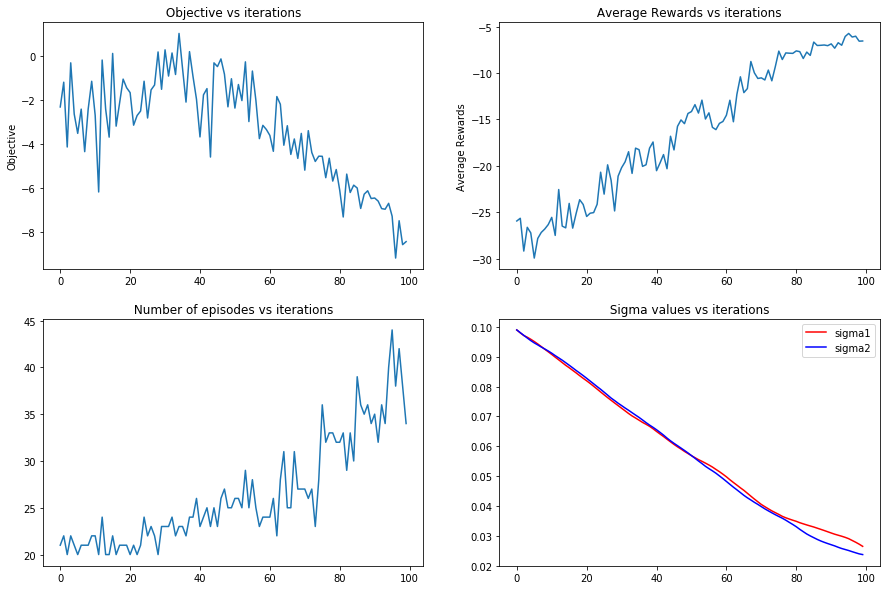

In [11]:
if plot:
    fig, axs = plt.subplots(2, 2, figsize=(15,10))
    axs = axs.flatten()
    axs[0].plot(arr_objective)
    axs[0].set_ylabel('Objective')
    axs[0].set_title(' Objective vs iterations ')
    axs[1].plot(avg_returns)
    axs[1].set_ylabel('Average Rewards')
    axs[1].set_title(' Average Rewards vs iterations ')
    axs[2].plot(num_episodes)
    axs[2].set_title(' Number of episodes vs iterations ')
    axs[3].plot(sigma[:,0], '-r')
    axs[3].plot(sigma[:,1], '-b')
    axs[3].set_title(' Sigma values vs iterations ')
    axs[3].legend(['sigma1', 'sigma2'])
    
    plt.show()

In [ ]:
if render_env:
    env = gym.make("modified_gym_env:ReacherPyBulletEnv-v1", rand_init=False)
    steps = 0
    env.render('human')
    state = env.reset()
    done = False
    time.sleep(1)
    while steps<300:
        a, _ = pg.getAction(policy_network, state)
        state, r, done, info = env.step(np.array(a))
        steps+=1
        env.render('human')
        time.sleep(0.1)
    print('Total steps = ', steps)
    env.env.close()

In [6]:
# pg.saveModel(4) #save model